# ANOVA



In [1]:
import pandas as pd

kids = pd.read_csv("https://github.com/febse/data/raw/main/econ/childiq.csv")[["kid_score", "mom_hs"]]
kids.head()

,kid_score,mom_hs
0,65,1
1,98,1
2,85,1
3,83,1
4,115,1


Beschreibung der Variablen in der Datei `kids.csv`:

-   `kid_score`: (numeric) Punkte im IQ-Test
-   `mom_hs` (numeric): 1 falls die Mutter des Kindes einen High School Abschluss hat, 0 sonst

In dieser Aufgabe werden wir annehmen, dass die Kinder rein zufällig aus allen Kindern im Alter zwischen 3 und 5 Jahren in den USA ausgewählt wurden (zur Zeit der Untersuchung).

Wir möchten die folgende Forschungsfrage untersuchen: Erreichen Kinder, deren Mutter keinen High School Abschluss hat, im Durchschnitt niedrigere IQ-Werte als Kinder, deren Mutter einen High School Abschluss hat?

/home/amarov/anaconda3/envs/econ2024/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/home/amarov/anaconda3/envs/econ2024/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/amarov/anaconda3/envs/econ2024/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0, 0.5, 'Bildung der Mutter')

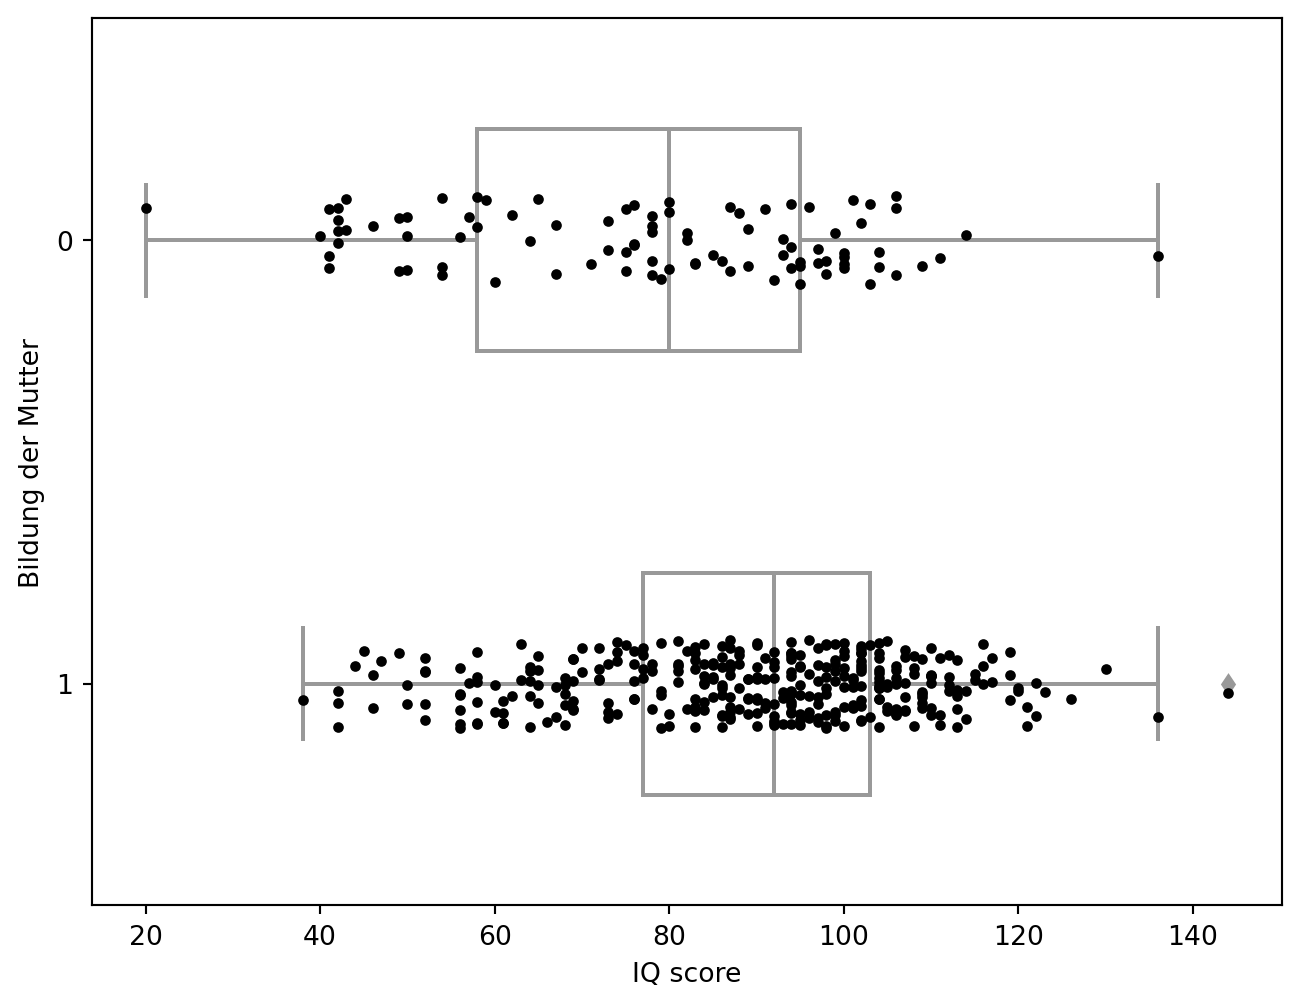

In [2]:
#| label: fig-kid-score-plot
#| fig-cap: "IQ scores of the children by the status of their mother (high school degree/no high school degree).  The plot adds a small amount of noise to the observations to avoid overplotting."

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming kids is a pandas DataFrame
kids['mom_hs'] = kids['mom_hs'].astype('category')

plt.figure(figsize=(8, 6))
sns.boxplot(x='kid_score', y='mom_hs', data=kids, color='white', width=0.5)
sns.stripplot(x='kid_score', y='mom_hs', data=kids, size=4, jitter=True, color='black')
plt.xlabel('IQ score')
plt.ylabel("Bildung der Mutter")

In [3]:
# Berechnen Sie die durchschnittlichen IQ-Scores für Kinder, deren Mütter einen High-School-Abschluss haben, und für Kinder,
# deren Mütter keinen High-School-Abschluss haben.



Berechnen Sie die Koeffizienten der folgenden Prognosegleichung für den IQ-Wert eines Kindes:

$$
\hat{y} = \beta_0 + \beta_1 \cdot x
$$

wobei $y$ der IQ-Wert des Kindes ist, $x$ die Variable `mom_hs` und $\hat{y}$ die Prognose für den IQ-Wert ist. Benutzen Sie
[https://febse.github.io/econ2024-de/03-KQ-Methode.html#%C3%BCbung](https://febse.github.io/econ2024-de/03-KQ-Methode.html#%C3%BCbung)

## Das Modell

$$
\begin{align*}
& i = 1,\ldots, n = 434 \text{ observations}\\
& y_i: \text{IQ score} \\
& \hat{y}_i: \text{Predicted IQ score} \\
& x_i \in \{0, 1\}: \text{status of the mother}
\end{align*}
$$

$$
y_i = \beta_0 + \beta_1 x_i + e_i, e_i \sim N(0, \sigma^2)
$$


$$
\begin{align*}
& y_i \sim N(\mu_i, \sigma^2), \quad i = 1,\ldots,n \\
& \mu_i = \beta_0 + \beta_1 x_i, \quad x_i \in \{0, 1\}
\end{align*}
$$ {#eq-simple-anova}

$$
\mu_1 = \beta_0 + \beta_1 \cdot 1
$$ {#eq-mu-x-1}

Für $x = 0$

$$
\mu_0 = \beta_0 + \beta_1 \cdot 0
$$ {#eq-mu-x-0}

Die Differenz der zwei Gleichungen [-@eq-mu-x-1] und [-@eq-mu-x-0] ergibt:

$$
\begin{align*}
\beta_0 & = \mu_0 \\
\beta_1 & = \mu_1 - \mu_0
\end{align*}
$$ 

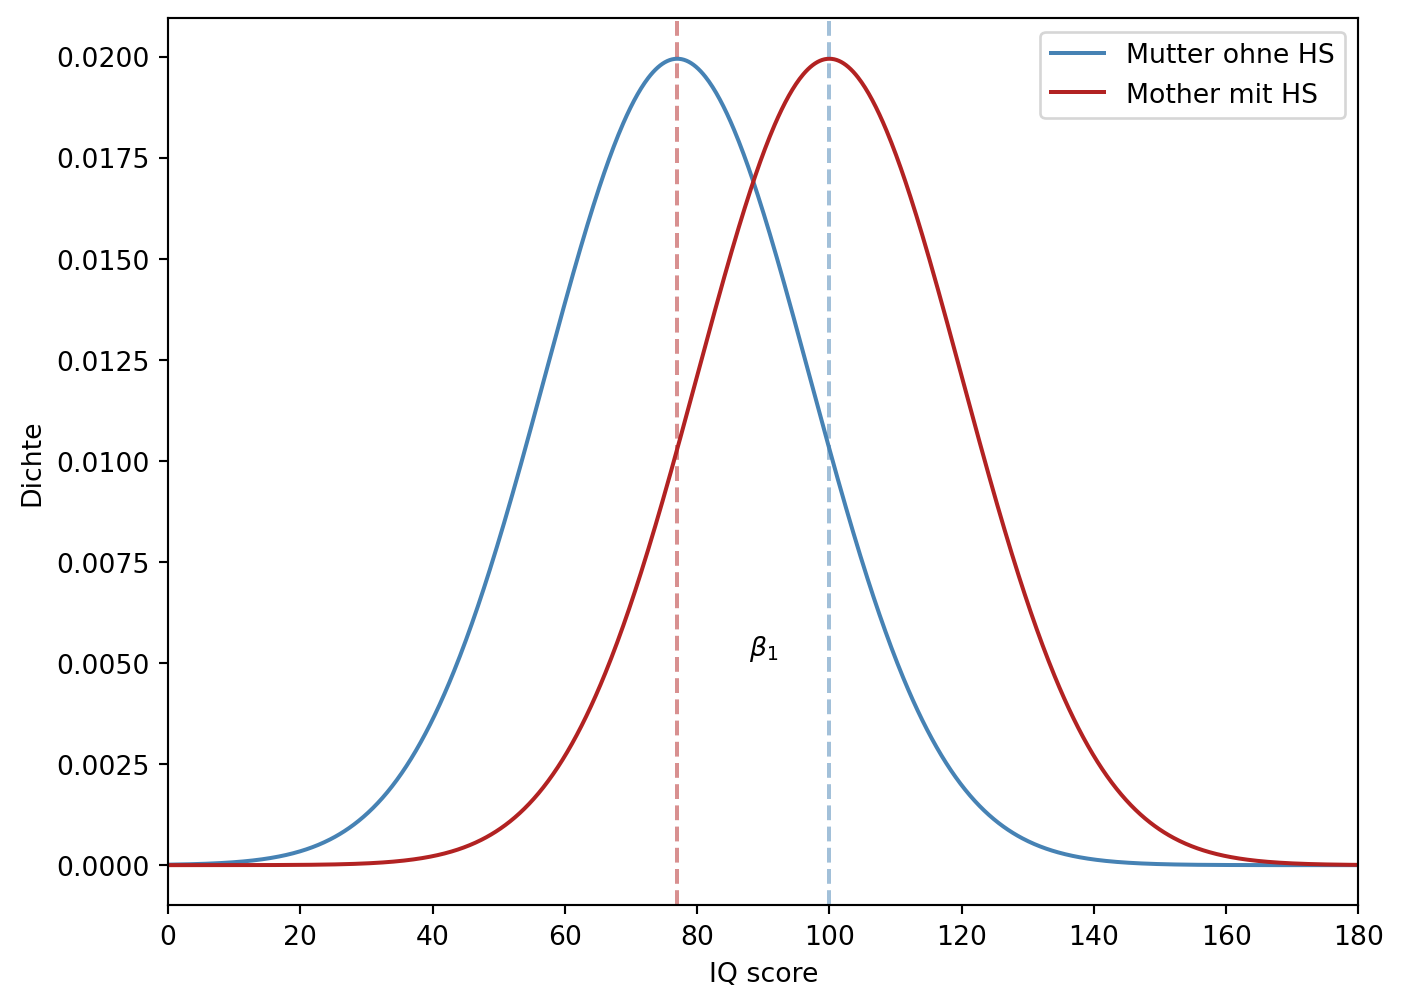

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the range of x
x = np.linspace(0, 180, 1000)

# Calculate the densities of the normal distributions
y1 = norm.pdf(x, loc=77, scale=20)
y2 = norm.pdf(x, loc=100, scale=20)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x, y1, color='steelblue', label='Mutter ohne HS')
plt.plot(x, y2, color='firebrick', label='Mother mit HS')
plt.axvline(x=77, linestyle='--', alpha=0.5, color='firebrick')
plt.axvline(x=100, linestyle='--', alpha=0.5, color='steelblue')
plt.text(90, 0.005, r'$\beta_1$', verticalalignment='bottom', horizontalalignment='center')
plt.xlim([0, 180])
plt.xlabel('IQ score')
plt.ylabel('Dichte')
plt.legend(loc='upper right')